In [86]:
# Essential Imports for the projects
import tensorflow as tf
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, SimpleRNN, Embedding, Dropout, SpatialDropout1D, Activation, Conv1D,GRU
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization, Add, Flatten
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from keras.optimizers import adam_v2
from keras.utils.vis_utils import plot_model
from sklearn.model_selection  import train_test_split

import keras.backend as K
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping 


import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt

plt.style.use('seaborn')

import seaborn as sns

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs
from nltk.tokenize import word_tokenize
import string
import gensim
import os
import re

sns.set_style("whitegrid")


In [87]:
# Read the train.csv file
train = pd.read_csv('train.csv')

In [88]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [89]:
# Shape of train.csv file
train.shape

(159571, 8)

In [90]:
# Columns of train.csv file
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [91]:
# Figuring out the comments which impacts the accuracy i.e. comments with some toxicity
train = train.loc[(train['toxic'] == 1) | (train['severe_toxic'] == 1) | (train['obscene'] ==1) | (train['threat'] == 1) | (train['insult'] == 1) | (train['identity_hate'] ==1)]

train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
44,001956c382006abd,I'm Sorry \n\nI'm sorry I screwed around with ...,1,0,0,0,0,0
51,001dc38a83d420cf,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
56,0020fd96ed3b8c8b,=Tony Sidaway is obviously a fistfuckee. He lo...,1,0,1,0,1,0
58,0021fe88bc4da3e6,My Band Page's deletion. You thought I was gon...,1,0,1,0,0,0


In [92]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,16225.000000,16225.000000,16225.000000,16225.000000,16225.000000,16225.000000
mean,0.942619,0.098305,0.520740,0.029461,0.485485,0.086595
std,0.232576,0.297736,0.499585,0.169099,0.499805,0.281249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [93]:
# Importing the Stopwords.
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
for i in range(ord('a'),ord('z')+1):
    stop_words.add(chr(i))

In [94]:
# Stemming and Lemmatizing
from nltk.stem import WordNetLemmatizer, PorterStemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [103]:
totalContentCleaned = []
newComments = []
punctList = {}
for punct in string.punctuation:
    punctList[punct] = None
transString = str.maketrans(punctList)
# Remove punctuation with ''
for sen in train['comment_text']:
    word_list = []
    for word in sen.split():
        if not word in stop_words:
            word_list.append(stemmer.stem(lemmatizer.lemmatize(word,pos="v")))
    totalContentCleaned = " ".join(word_list)
    # print(totalContentCleaned)
    newComments.append(totalContentCleaned.translate(transString))

# print(newComments)
train['comment_text'] = newComments
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,cocksuck befor piss around work,1,1,1,0,1,0
12,0005c987bdfc9d4b,hey it talk it exclu group wp talibanswho g...,1,0,0,0,0,0
16,0007e25b2121310b,bye look come think com back tosser,1,0,0,0,0,0
42,001810bf8c45bf5f,gay antisemmitian archangel white tiger meow g...,1,0,1,0,1,1
43,00190820581d90ce,fuck filthi mother ass dry,1,0,1,0,1,0
44,001956c382006abd,im sorri im sorri screw around someon talk pag...,1,0,0,0,0,0
51,001dc38a83d420cf,get fuck up get fucke up get drink cant put do...,1,0,1,0,0,0
55,0020e7119b96eeeb,stupid peac shit stop delet stuff asshol go di...,1,1,1,0,1,0
56,0020fd96ed3b8c8b,toni sidaway obviou fistfuckee love arm ass,1,0,1,0,1,0
58,0021fe88bc4da3e6,band page deletion think gone delet comment po...,1,0,1,0,0,0


In [96]:
df_test = pd.read_csv('test.csv')
df_test.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [98]:
df_test_labels = pd.read_csv('test_labels.csv')
df_test_labels.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
5,0001ea8717f6de06,0,0,0,0,0,0
6,00024115d4cbde0f,-1,-1,-1,-1,-1,-1
7,000247e83dcc1211,0,0,0,0,0,0
8,00025358d4737918,-1,-1,-1,-1,-1,-1
9,00026d1092fe71cc,-1,-1,-1,-1,-1,-1


In [99]:
test_labels = df_test_labels[(df_test_labels[['toxic','severe_toxic', 'obscene', 'threat', 
                                        'insult', 'identity_hate']] != -1).all(axis=1)]
test_labels.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,0,0,0,0,0,0
11,0002f87b16116a7f,0,0,0,0,0,0
13,0003e1cccfd5a40a,0,0,0,0,0,0
14,00059ace3e3e9a53,0,0,0,0,0,0
16,000663aff0fffc80,0,0,0,0,0,0
17,000689dd34e20979,0,0,0,0,0,0
19,000844b52dee5f3f,0,0,0,0,0,0
21,00091c35fa9d0465,1,0,0,0,0,0
22,000968ce11f5ee34,0,0,0,0,0,0


In [100]:
test = pd.merge(test_labels, df_test, on='id', how='inner')
test.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
0,0001ea8717f6de06,0,0,0,0,0,0,Thank you for understanding. I think very high...
1,000247e83dcc1211,0,0,0,0,0,0,:Dear god this site is horrible.
2,0002f87b16116a7f,0,0,0,0,0,0,"""::: Somebody will invariably try to add Relig..."
3,0003e1cccfd5a40a,0,0,0,0,0,0,""" \n\n It says it right there that it IS a typ..."
4,00059ace3e3e9a53,0,0,0,0,0,0,""" \n\n == Before adding a new product to the l..."
5,000663aff0fffc80,0,0,0,0,0,0,this other one from 1897
6,000689dd34e20979,0,0,0,0,0,0,== Reason for banning throwing == \n\n This ar...
7,000844b52dee5f3f,0,0,0,0,0,0,|blocked]] from editing Wikipedia. |
8,00091c35fa9d0465,1,0,0,0,0,0,"== Arabs are committing genocide in Iraq, but ..."
9,000968ce11f5ee34,0,0,0,0,0,0,Please stop. If you continue to vandalize Wiki...


In [101]:
# Taking only toxicity comments in the test dataset
test = test.loc[(test['toxic'] == 1) | (test['severe_toxic'] == 1) | (test['obscene'] ==1) | (test['threat'] == 1) | (test['insult'] == 1) | (test['identity_hate'] ==1)]

test.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
8,00091c35fa9d0465,1,0,0,0,0,0,"== Arabs are committing genocide in Iraq, but ..."
24,0013fed3aeae76b7,1,0,1,0,1,1,DJ Robinson is gay as hell! he sucks his dick ...
29,0017d4d47894af05,1,0,1,0,1,0,":Fuck off, you anti-semitic cunt. |"
38,001d739c97bc2ae4,1,0,0,0,0,0,How dare you vandalize that page about the HMS...
40,001eff4007dbb65b,1,0,1,0,1,0,"::No, he is an arrogant, self serving, immatur..."
89,005f47397e07e12f,1,0,0,0,0,0,":Eek, but shes cute in an earthy kind of way. ..."
106,0071940212267fea,1,0,1,0,0,0,"::::Well, it sucks to have a university to be ..."
107,0072b9c3697ab8cc,1,0,1,0,1,0,== Argh == \n\n Some random idiot deleted the ...
124,0081b14d79f54b31,1,0,1,1,0,0,(we hate america and we are going to bomb the ...
125,00842d1024b19972,1,0,1,0,1,0,== Bold textYOU SUCK!!! == \n\n \n\n U SUCK H...


In [104]:
totalContentCleaned = []
newComments = []
punctDict = {}
for punct in string.punctuation:
    punctDict[punct] = None
transString = str.maketrans(punctDict)
# since we intent to remove any punctuation with ''
for sen in test['comment_text']:
    word_list = []
    for word in sen.split():
        if not word in stop_words:
            word_list.append(stemmer.stem(lemmatizer.lemmatize(word,pos="v")))
    totalContentCleaned = " ".join(word_list)
    # print(totalContentCleaned)
    newComments.append(totalContentCleaned.translate(transString))

# print(newComments)
test['comment_text'] = newComments
test.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
8,00091c35fa9d0465,1,0,0,0,0,0,arab commit genocid iraq protest europe may ...
24,0013fed3aeae76b7,1,0,1,0,1,1,dj robinson gay hell suck dick much
29,0017d4d47894af05,1,0,1,0,1,0,fuck off antisemit cunt
38,001d739c97bc2ae4,1,0,0,0,0,0,dare vandal page hm beagle vandal again demon
40,001eff4007dbb65b,1,0,1,0,1,0,no arrogant self serving immatur idiot get right
89,005f47397e07e12f,1,0,0,0,0,0,eek cute earthi kind way cant sing shit though...
106,0071940212267fea,1,0,1,0,0,0,well suck univ nicknameless first time ncaa hi...
107,0072b9c3697ab8cc,1,0,1,0,1,0,argh random idiot delet whole japan articl
124,0081b14d79f54b31,1,0,1,1,0,0,we hate america go bomb shit cities queza rain
125,00842d1024b19972,1,0,1,0,1,0,bold textyou suck suck hannah montana


In [62]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,16225.000000,16225.000000,16225.000000,16225.000000,16225.000000,16225.000000
mean,0.942619,0.098305,0.520740,0.029461,0.485485,0.086595
std,0.232576,0.297736,0.499585,0.169099,0.499805,0.281249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [105]:
#Shapes of the datsets present
print("Train data shape", train.shape)
print("Test data shape", test.shape)

Train data shape (16225, 8)
Test data shape (6243, 8)


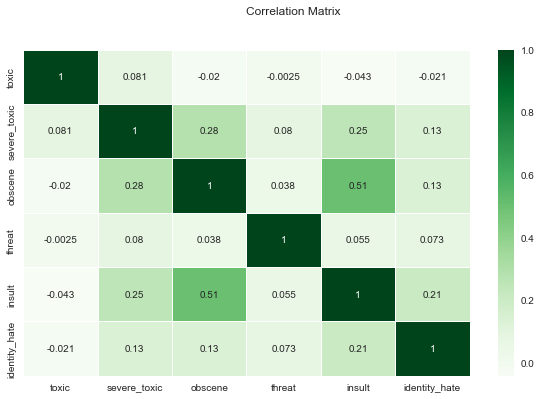

In [106]:
#Checking Co-relation b/w various attributes
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Correlation Matrix')
sns.heatmap(train.corr(), annot=True, cmap="Greens", linewidths=.5, ax=ax);

In [107]:
#Splitting Datasets
X_train = train["comment_text"].values
X_test  = test["comment_text"].values

y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
y_test  = test[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

In [108]:
num_words = 20000 # Number of words to be used in one toxic comment used in tokenizer.
max_len = 200 #Max. number of words per toxic comment to be use
embedding_dims = 100 #embedding vector output dimension 
num_epochs = 10 
batch_size = 32 # Number of texts to be processed in one epoch. Greater number beneficial

In [109]:
#toxic comments Tokenization
tokenizer = tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(list(X_train))

#Convert tokenized toxic commnent to sequnces
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
 
# padding the sequences
X_train = sequence.pad_sequences(X_train, max_len)
X_test  = sequence.pad_sequences(X_test,  max_len)

print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape: (16225, 200)
X_test shape:  (6243, 200)


In [110]:
X_tra, X_val, y_tra, y_val = train_test_split(X_train, y_train, train_size =0.8, random_state=233)
print(X_tra.shape)
print(X_val.shape)

(12980, 200)
(3245, 200)


LSTM with Glove

In [111]:
#Load the glove vectors file
glove_file = open('glove.6B.100d.txt', encoding="utf8")
embeddings_index = dict()
for line in glove_file:
    val = line.split(' ')
    word = val[0]
    coefs = np.asarray(val[1:], dtype='float32')
    embeddings_index[word] = coefs
glove_file.close()

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [112]:
# create a weight matrix
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 100))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [113]:
LSTM_Glove_model = Sequential([
    Embedding(input_dim =embedding_matrix.shape[0], input_length=max_len, output_dim=embedding_matrix.shape[1],weights=[embedding_matrix], trainable=False),
    SpatialDropout1D(0.5),
    LSTM(25, return_sequences=True), 
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

LSTM_Glove_model.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam(0.01), metrics=['accuracy'])

In [114]:
LSTM_Glove_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 100)          3679500   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 200, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 200, 25)           12600     
                                                                 
 batch_normalization_1 (Batc  (None, 200, 25)          100       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 200, 25)           0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 25)              

In [115]:
LSTM_Glove_model_fit = LSTM_Glove_model.fit(X_tra, y_tra, batch_size=batch_size, epochs=num_epochs, validation_data=(X_val, y_val))

Epoch 1/10
406/406 [==============================] - 116s 241ms/step - loss: 0.3639 - accuracy: 0.9378 - val_loss: 0.3866 - val_accuracy: 0.9445
Epoch 2/10
406/406 [==============================] - 90s 222ms/step - loss: 0.3378 - accuracy: 0.9398 - val_loss: 0.3447 - val_accuracy: 0.9445
Epoch 3/10
406/406 [==============================] - 97s 240ms/step - loss: 0.3288 - accuracy: 0.9418 - val_loss: 0.3379 - val_accuracy: 0.9445
Epoch 4/10
406/406 [==============================] - 90s 221ms/step - loss: 0.3265 - accuracy: 0.9412 - val_loss: 0.3306 - val_accuracy: 0.9433
Epoch 5/10
406/406 [==============================] - 91s 223ms/step - loss: 0.3225 - accuracy: 0.9388 - val_loss: 0.3228 - val_accuracy: 0.9445
Epoch 6/10
406/406 [==============================] - 93s 228ms/step - loss: 0.3235 - accuracy: 0.9421 - val_loss: 0.3296 - val_accuracy: 0.9445
Epoch 7/10
406/406 [==============================] - 68s 168ms/step - loss: 0.3211 - accuracy: 0.9421 - val_loss: 0.3201 - val_a

In [116]:
#train
LSTM_Glove_train_score = LSTM_Glove_model.evaluate(X_tra, y_tra, batch_size=batch_size, verbose=1)
print('Train Loss:', LSTM_Glove_train_score[0])
print('Train Accuracy:', LSTM_Glove_train_score[1])

#test
LSTM_Glove_test_score = LSTM_Glove_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test Loss:', LSTM_Glove_test_score[0])
print('Test Accuracy:', LSTM_Glove_test_score[1])

406/406 [==============================] - 21s 52ms/step - loss: 0.3064 - accuracy: 0.9421
Train Loss: 0.30642232298851013
Train Accuracy: 0.9421417713165283
196/196 [==============================] - 11s 53ms/step - loss: 0.3123 - accuracy: 0.9755
Test Loss: 0.31231871247291565
Test Accuracy: 0.975492537021637


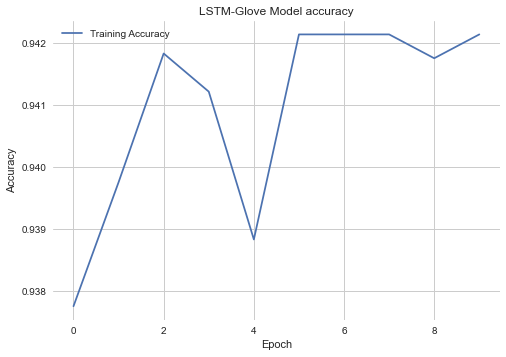

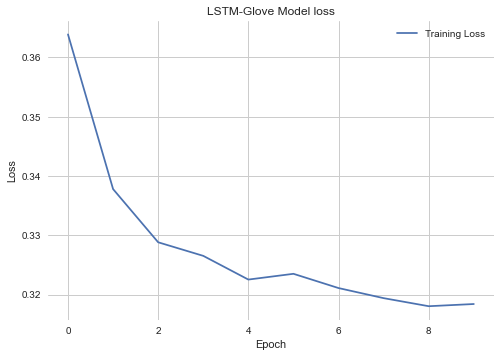

In [118]:
### Plot Training Accuracy with the Loss values of the LSTM-Glove Model
plt.plot(LSTM_Glove_model_fit.history['accuracy'])
plt.title('LSTM-Glove Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy'], loc='upper left')
plt.show()

# Plot training loss values
plt.plot(LSTM_Glove_model_fit.history['loss'])
plt.title('LSTM-Glove Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss'], loc='upper right')
plt.show()